# Chapter 4&5: Expiration PnL and Theoretical Pricing Models

This notebook explores foundational concepts from Chapter 4 and Chapter 5. The content focuses on visualising how option positions behave at expiration and introduces a basic approach to pricing options using probabilities. Chapter 5 briefly introduced the Black-Scholes Model as well.

# **Table of Contents**  
1. [Payoff Visualiser](#payoff)  
2. [Combined Expiration PnL Graph Generator](#combined-pnl)  
3. [Theoretical Option Pricing Simulator](#Theoretical-Option-Pricing-Simulator)  

## <a id='payoff'></a> 1. Payoff Visualiser

Visualise the payoff profile of an individual option or underlying postion at expiration.

In [17]:
# Payoff visualiser
import matplotlib.pyplot as plt
import numpy as np

def plot_payoff_diagram(strike_price, position_type='call', quantity=1, underlying=False):
    """
    Parameters:
    - strike_price: The strike price of the option
    - position_type: 'call' or 'put'
    - quantity: Number of contracts (positive for long, negative for short)
    - underlying: Set to True if this is an underlying (stock) position
    """
    S = np.linspace(strike_price * 0.5, strike_price * 1.5, 100)

    if underlying:
        payoff = (S - strike_price) * quantity
        label = f"{'Long' if quantity > 0 else 'Short'} Underlying"
    elif position_type == 'call':
        payoff = np.maximum(S - strike_price, 0) * quantity
        label = f"{'Long' if quantity > 0 else 'Short'} Call Option"
    elif position_type == 'put':
        payoff = np.maximum(strike_price - S, 0) * quantity
        label = f"{'Long' if quantity > 0 else 'Short'} Put Option"
    else:
        raise ValueError("position_type must be 'call' or 'put'")

    plt.plot(S, payoff, label=label)
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(strike_price, color='red', linestyle='--', label='Strike Price')
    plt.xlabel("Stock Price at Expiration")
    plt.ylabel("Payoff")
    plt.title("Option Payoff Diagram")
    plt.legend()
    plt.grid(True)
    plt.show()


### Example Usage

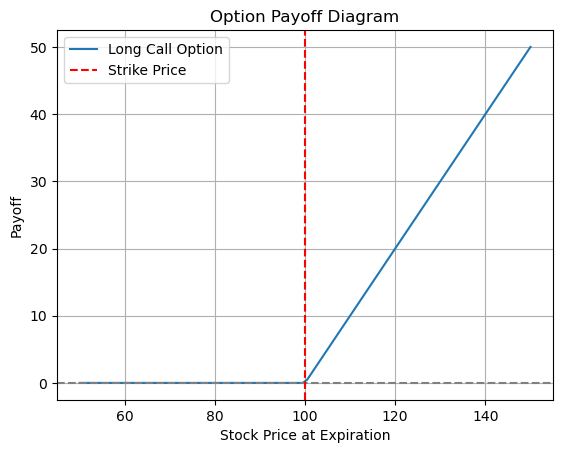

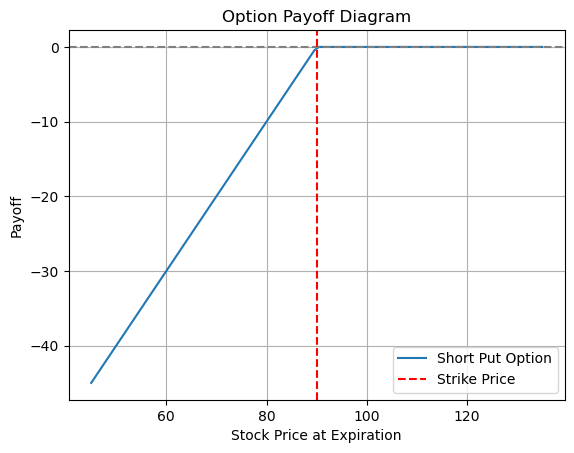

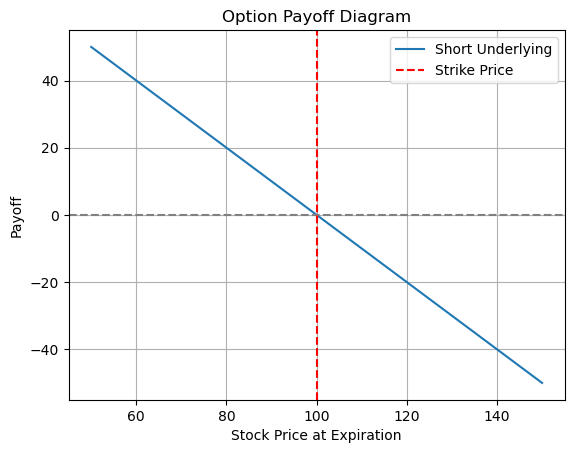

In [18]:
# Long call with strike 100
plot_payoff_diagram(strike_price=100, position_type='call', quantity=1)

# Short put with strike 90
plot_payoff_diagram(strike_price=90, position_type='put', quantity=-1)

# Short stock position (short 1 share at $100)
plot_payoff_diagram(strike_price=100, underlying=True, quantity=-1)

## <a id='combined-pnl'></a> 2. Combined Expiration PnL Graph Generator

Combine multiple options and/or underlying to simulate total expiration PnL.

In [76]:
def combined_expiration_pnl(components):
    # Determine relevant price range
    all_strikes = [comp['strike_price'] for comp in components]
    min_strike = min(all_strikes)
    max_strike = max(all_strikes)

    # Handle case where all strikes are the same
    if min_strike == max_strike:
        buffer = min_strike * 0.4  
    else:
        buffer = (max_strike - min_strike) * 0.5
    S_base = np.linspace(min_strike - buffer, max_strike + buffer, 400)
    
    # Force include key price levels 
    important_levels = set(all_strikes)

    # Merge and sort unique price points into the grid
    S = np.unique(np.concatenate((S_base, np.array(list(important_levels)))))
    
    # Initialize an array to accumulate total PnL across all components
    total_pnl = np.zeros_like(S)
    net_cost = 0

    # Loop through each position (option or underlying)
    for comp in components:
        # For underlying (e.g., stock/futures), pnl is linear: (S - entry price) * quantity
        if comp['underlying']:
            pnl = (S - comp['strike_price']) * comp['quantity']
            cost = 0
        
        # For call options, pnl is: max(S - K, 0) - premium, then multiplied by quantity
        elif comp['type'] == 'call':
            pnl = (np.maximum(S - comp['strike_price'], 0) - comp['premium']) * comp['quantity']
            cost = comp['premium'] * comp['quantity']
        
        # For put options, pnl is: max(K - S, 0) - premium, then multiplied by quantity
        elif comp['type'] == 'put':
            pnl = (np.maximum(comp['strike_price'] - S, 0) - comp['premium']) * comp['quantity']
            cost = comp['premium'] * comp['quantity']

        # Accumulate each leg’s pnl and cost into the total pnl array
        total_pnl += pnl
        net_cost += -cost
        
        # Label the line: either 'Underlying' or 'Call xN' / 'Put xN'
        label = f"{'Underlying' if comp['underlying'] else comp['type'].capitalize()} x{comp['quantity']}"
        plt.plot(S, pnl, label=label)  # Plot individual leg

    # Plot total combined PnL of all positions
    plt.plot(S, total_pnl, label='Total Position', linewidth=2, linestyle='--')
     
    # Check slopes at both ends of the price range
    left_slope = total_pnl[1] - total_pnl[0]
    right_slope = total_pnl[-1] - total_pnl[-2]

    # Detect unlimited behavior based on increasing/decreasing pnl
    # Left side (low price range)
    if left_slope < 0:
        plt.text(S[0], total_pnl[0], 'Max Gain: Unlimited', color='green', fontsize=9, ha='left')
    elif left_slope > 0:
        plt.text(S[0], total_pnl[0], 'Max Loss: Unlimited', color='red', fontsize=9, ha='left')

    # Right side (high price range)
    if right_slope > 0:
        plt.text(S[-1], total_pnl[-1], 'Max Gain: Unlimited', color='green', fontsize=9, ha='right')
    elif right_slope < 0:
        plt.text(S[-1], total_pnl[-1], 'Max Loss: Unlimited', color='red', fontsize=9, ha='right')

    # Only plot max gain/loss values if slope is not trending indefinitely
    if left_slope >= 0 and right_slope <= 0:
        max_profit = np.max(total_pnl)
        idx = np.argmax(total_pnl)
        plt.text(S[idx], max_profit, f'Max Gain: {max_profit:.2f}', color='green', fontsize=9)

    if left_slope <= 0 and right_slope >= 0:
        max_loss = np.min(total_pnl)
        idx = np.argmin(total_pnl)
        plt.text(S[idx], max_loss, f'Max Loss: {max_loss:.2f}', color='red', fontsize=9)
    
    # Plot breakeven point
    for i in range(1, len(S)):
        if total_pnl[i-1] * total_pnl[i] < 0:  # Sign change
            breakeven = S[i-1] + (S[i] - S[i-1]) * (-total_pnl[i-1]) / (total_pnl[i] - total_pnl[i-1])
            plt.axvline(breakeven, color='purple', linestyle=':', alpha=0.6)
            plt.text(breakeven, 0, f'BE: {breakeven:.2f}', rotation=90, va='bottom', ha='right', color='purple')

 
    plt.title(f"Combined Expiration PnL\nNet Cost: ${net_cost:.2f}")
    plt.axhline(0, color='gray', linestyle=':')
    plt.xlabel("Stock Price at Expiration")
    plt.ylabel("Profit / Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

### Example Usage

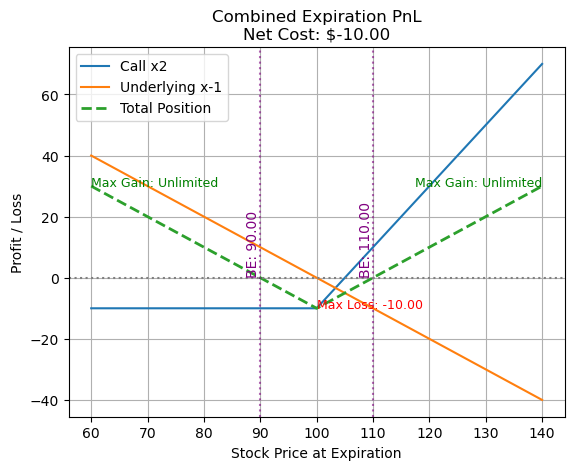

In [77]:
# Example: Long 2 calls + Short underlying
components = [{'type': 'call', 'strike_price': 100, 'premium': 5, 'quantity': 2, 'underlying': False},
              {'type': 'underlying', 'strike_price': 100, 'premium': 0, 'quantity': -1, 'underlying': True}]

combined_expiration_pnl(components)

## <a id='Theoretical-Option-Pricing-Simulator'></a> 3. Theoretical Option Pricing Simulator

This application simulates a theoretical value for a European-style option based on discrete possible expiration prices and their assigned probabilities.

According to Chapter 5, to price an option using this method:
1. Propose a set of possible underlying prices at expiration.
2. Assign probabilities to each price.
3. Ensure the expected value of the underlying = forward price (arbitrage-free condition).
4. Compute the expected value of the option’s payoff.
5. Discount this value to get the theoretical price.

We simulate this for both call and put options.

In [67]:
# Defining the validation function
def validate_forward_price(price_scenarios, probabilities, forward_price, tolerance=1e-4):
    """
    Ensures the expected value of the underlying matches the forward price.
    """
    expected_value = sum(p * s for p, s in zip(probabilities, price_scenarios))
    if abs(expected_value - forward_price) > tolerance:
        raise ValueError(
            f"Expected value ({expected_value:.4f}) does not match forward price ({forward_price:.4f})."
        )
    print(f"Forward price condition met: Expected value ≈ {expected_value:.4f}")
    return True

In [72]:
# Defining the pricing function
def calculate_theoretical_option_value(option_type, strike_price, price_scenarios, probabilities, forward_price, discount_factor=1.0):
    """
    Computes the theoretical value of a European option using price outcomes and probabilities.
    """
    # Step 1: Validate arbitrage-free condition
    validate_forward_price(price_scenarios, probabilities, forward_price)

    # Step 2: Calculate option payoffs
    if option_type == 'call':
        payoffs = [max(price - strike_price, 0) for price in price_scenarios]
    elif option_type == 'put':
        payoffs = [max(strike_price - price, 0) for price in price_scenarios]
    else:
        raise ValueError("Invalid option_type. Must be 'call' or 'put'.")

    # Step 3: Calculate expected payoff
    expected_payoff = sum(p * v for p, v in zip(probabilities, payoffs))

    # Step 4: Discount to present value
    theoretical_value = expected_payoff/discount_factor

    print(f"Theoretical {option_type.capitalize()} Option Value: ${theoretical_value:.4f}")
    return round(theoretical_value,2)

### Example Usage

In [73]:
price_scenarios = [83, 90, 99, 110, 123]
probabilities = [0.06, 0.15, 0.39, 0.33, 0.07]
calculate_theoretical_option_value(
    option_type='call',
    strike_price=100,
    price_scenarios=price_scenarios,
    forward_price=102,
    probabilities=probabilities,
    discount_factor=1.02)

Forward price condition met: Expected value ≈ 102.0000
Theoretical Call Option Value: $4.8137


4.81

This pricing simulator demonstrates how options can be valued using simple discrete distributions, assuming arbitrage-free conditions. We validated that the expected value of the underlying matches the forward price and calculated the present value of the expected option payoff.

In future chapters, we will refine this model using continuous distributions and volatility inputs (e.g., Black-Scholes).